<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Transfer_DenseNet121_50_10_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DenseNet121**

# Check GPU

In [0]:
!nvidia-smi

Fri Jun 12 19:10:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from pj61403_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should 

In [0]:
tf.compat.v1.disable_eager_execution()

# Data

## Clone Data

In [0]:
!git clone https://github.com/EvilPickle-PCSHSPT/PJ61403_DATA_split_50-10-40

fatal: destination path 'PJ61403_DATA_split_50-10-40' already exists and is not an empty directory.


## Hyperparameters

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

EPOCHS = 100

BATCH_SIZE = 32

LR = 1e-3

In [0]:
train_dir = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/train'

val_dir = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/val'

test_dir = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/test'

### Data Augmentation

In [0]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_aug.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode ='categorical')

val_generator = val_aug.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                class_mode='categorical')

test_generator = test_aug.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 121 images belonging to 4 classes.
Found 22 images belonging to 4 classes.
Found 101 images belonging to 4 classes.


# Model

## Base Model

In [0]:
base_model = tf.keras.models.load_model('/content/6_scratch_CW_densenet121_84_model_1.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [0]:
num_layers = len(base_model.layers)

In [0]:
num_layers

429

## New Model

In [0]:
for i in range(num_layers):
    base_model.layers[i].trainable = False

x = base_model.layers[num_layers-2].output
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.25)(x)

prediction = Dense(4, activation='softmax')(x)

new_model = Model(inputs=base_model.input,outputs=prediction)

new_model.compile(optimizer=Adam(LR), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [0]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='/content/pj61043_densenet121_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7 , patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [0]:
history = new_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS,
                        callbacks=[early_stop, model_checkpoint, reduce_lr_rate])

Epoch 1/100
4/4 [==============================] - 113s 28s/step - loss: 1.4095 - accuracy: 0.4132 - val_loss: 1.2614 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 2s 427ms/step - loss: 1.0898 - accuracy: 0.4793 - val_loss: 1.1458 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 4s 998ms/step - loss: 0.8491 - accuracy: 0.6198 - val_loss: 0.9755 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 4s 965ms/step - loss: 0.6959 - accuracy: 0.7355 - val_loss: 0.8667 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 4s 989ms/step - loss: 0.5524 - accuracy: 0.8017 - val_loss: 0.8143 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 4s 1s/step - loss: 0.5205 - accuracy: 0.7851 - val_loss: 0.7015 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 4s 969ms/step - loss: 0.4792

# Graph

## Accuracy

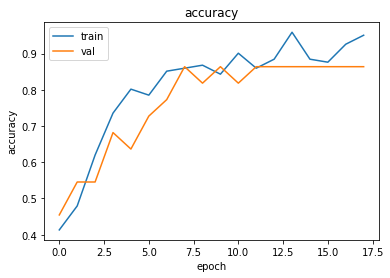

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

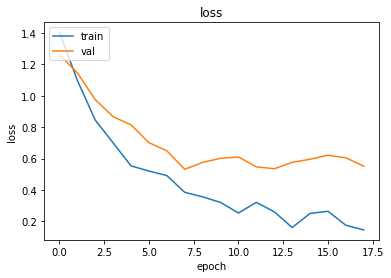

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
test_model = tf.keras.models.load_model('/content/pj61043_densenet121_model.h5')

In [0]:
num_test_files = len(test_generator.filenames)

In [0]:
test_generator.reset()

In [0]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

Confusion matrix, without normalization
[[20  4  3  0]
 [ 0 24  0  0]
 [ 0  8 18  0]
 [ 1  0  1 22]]


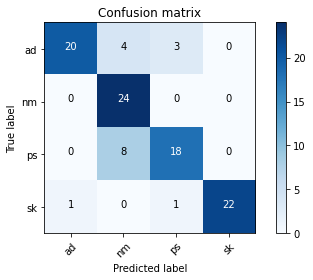

In [0]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['ad', 'nm', 'ps', 'sk']

plot_confusion_matrix(cm, classes_names, False)

Normalized confusion matrix
[[0.74074074 0.14814815 0.11111111 0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.30769231 0.69230769 0.        ]
 [0.04166667 0.         0.04166667 0.91666667]]


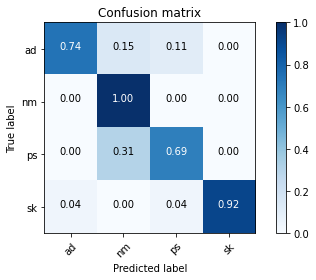

In [0]:
plot_confusion_matrix(cm, classes_names, True)

In [0]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[20  4  3  0]
 [ 0 24  0  0]
 [ 0  8 18  0]
 [ 1  0  1 22]]
Classification Report
              precision    recall  f1-score   support

          ad       0.95      0.74      0.83        27
          nm       0.67      1.00      0.80        24
          ps       0.82      0.69      0.75        26
          sk       1.00      0.92      0.96        24

    accuracy                           0.83       101
   macro avg       0.86      0.84      0.83       101
weighted avg       0.86      0.83      0.83       101



In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [0]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.8333
specificity: 1.0000


# Grad-CAM

In [0]:
last_conv2d = 'conv5_block16_2_conv'

## AD

In [0]:
ad_img = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/test/ad/ad1.jpg'

Model prediction:
	ad             	(0)	with probability 0.796
	ps             	(2)	with probability 0.140
	nm             	(1)	with probability 0.062
	sk             	(3)	with probability 0.002
Explanation for 'ad'


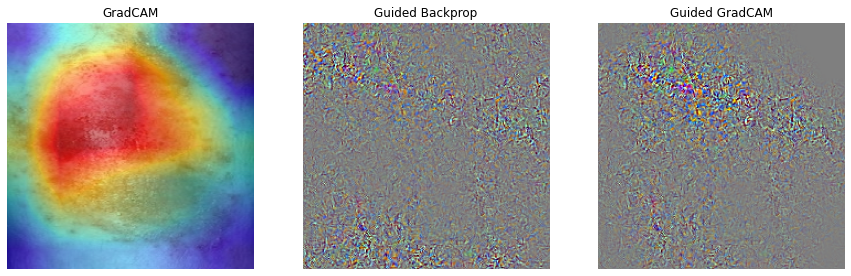

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ad_img, layer_name=last_conv2d)

## NM

In [0]:
nm_img = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/test/nm/nm4.jpg'

Model prediction:
	nm             	(1)	with probability 0.967
	ad             	(0)	with probability 0.020
	sk             	(3)	with probability 0.011
	ps             	(2)	with probability 0.002
Explanation for 'nm'


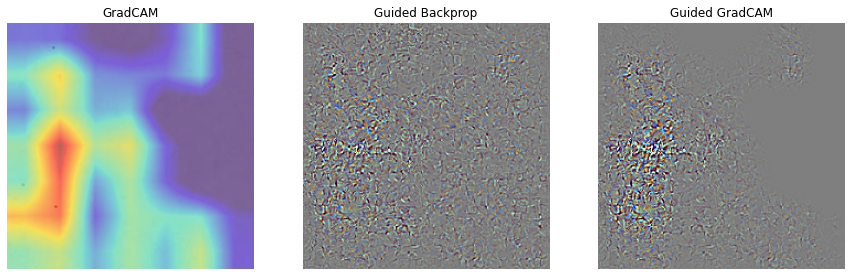

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, nm_img, layer_name=last_conv2d)

## PS

In [0]:
ps_img = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/test/ps/ps3.jpg'

Model prediction:
	nm             	(1)	with probability 0.484
	ad             	(0)	with probability 0.348
	sk             	(3)	with probability 0.124
	ps             	(2)	with probability 0.044
Explanation for 'nm'


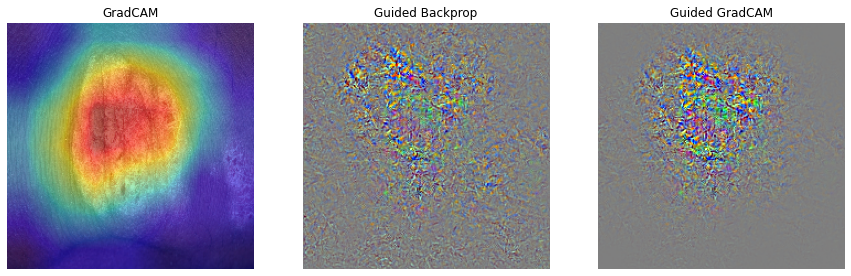

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, ps_img, layer_name=last_conv2d)

## SK

In [0]:
sk_img = '/content/PJ61403_DATA_split_50-10-40/crop_split_classes_data/test/sk/sk4.jpg'

Model prediction:
	sk             	(3)	with probability 0.607
	nm             	(1)	with probability 0.299
	ad             	(0)	with probability 0.049
	ps             	(2)	with probability 0.045
Explanation for 'sk'


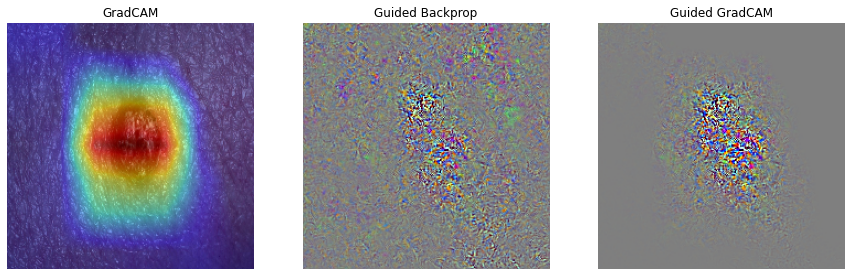

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, sk_img, layer_name=last_conv2d)

# Download

In [0]:
from google.colab import files

files.download('/content/pj61043_densenet121_model_1.h5')